In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import seaborn as sns
import pandas as pd
import numpy as np
import folium

%matplotlib inline

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.style.use(['ggplot', 'seaborn-poster'])

params = {'text.color': 'w',
          'ytick.color' : 'w',
          'xtick.color': 'w',
          'axes.labelcolor': 'w',
          'axes.edgecolor': 'w'}

plt.rcParams.update(params)

In [3]:
def apply_price_formatter(ax, yaxis=True):
    """
    Applies price formatter to given ax.
    If yaxis is set to False, the x-axis will be formatted instead.
    """
    if yaxis:
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
    else:
        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

In [4]:
df = pd.read_csv('preprocessed_df.csv', index_col=0)
df.head()

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,renovated
0,221900,3,1.00,5650,1.0,0.0,3,7,1180,0,98178,1340,5650,0.0
1,538000,3,2.25,7242,2.0,0.0,3,7,2170,400,98125,1690,7639,1.0
2,180000,2,1.00,10000,1.0,0.0,3,6,770,0,98028,2720,8062,0.0
3,604000,4,3.00,5000,1.0,0.0,5,7,1050,910,98136,1360,5000,0.0
4,510000,3,2.00,8080,1.0,0.0,3,8,1680,0,98074,1800,7503,0.0


# Figures `dict()`

In [5]:
figures_dct = dict()

# ***zipcode***

## Folium

In [6]:
loc_df = pd.read_csv('kc_house_data.csv')[['price', 'zipcode', 
                                           'lat', 'long', 'waterfront']]
loc_df.head()

,price,zipcode,lat,long,waterfront
0,221900.0,98178,47.5112,-122.257,NaN
1,538000.0,98125,47.7210,-122.319,0.0
2,180000.0,98028,47.7379,-122.233,0.0
3,604000.0,98136,47.5208,-122.393,0.0
4,510000.0,98074,47.6168,-122.045,0.0


In [7]:
# Find center of each zipcode.
z = loc_df.groupby('zipcode')

# Find the central point of of each zipcode 
# (based on top and bottom (lat, long) limits)
zip_center = {
    zipcode: (z.get_group(zipcode).max()['lat'] - 
              (z.get_group(zipcode).max()['lat'] - 
               z.get_group(zipcode).min()['lat']), 
              z.get_group(zipcode).max()['long'] - 
              (z.get_group(zipcode).max()['long'] - 
               z.get_group(zipcode).min()['long']))
    for zipcode in list(set(loc_df['zipcode'].values))
}

# Example
zip_center[98177]

(47.7013, -122.39299999999999)

In [8]:
color_gradient = {
    5: 'darkblue',
    4: 'blue',
    3: 'darkblue',
    2: 'darkred',
    1: 'red',
    0: 'lightred'
}

In [9]:
# Find the prices outlining each quantile.
quantile_dct = {
    x: z.median()['price'].quantile(q) 
    for x, q in enumerate(np.linspace(0.1, 1, 6))
}
quantile_dct

{0: 268352.5, 1: 342160.0, 2: 432400.0, 3: 545800.0, 4: 665539.5, 5: 1895000.0}

In [10]:
# Set up map.
fol_map_zip = folium.Map(location=[47.5112, -122.257], 
                     zoom_start=9, tiles='Stamen Terrain')

for zipcode, (lat, long) in zip_center.items():
    for i in range(6):
        if z.get_group(zipcode).median()['price'] < quantile_dct[i]:
            color = color_gradient[i]
            break
    
    marker = folium.Marker(
        [lat, long],
        icon=folium.Icon(color=color)
        )
    marker.add_to(fol_map_zip)

fol_map_zip

In [11]:
fol_map_zip.save('presentation_visualizations/fol_map_zip.html')

## Barplot

In [12]:
median_price = z.median().reset_index()[['zipcode', 'price']]
median_price.sort_values('price', ascending=False, inplace=True)
median_price['zipcode'] = median_price['zipcode'].astype(str)
median_price.head()

,zipcode,price
24,98039,1895000.0
3,98004,1150000.0
25,98040,993750.0
48,98112,915000.0
4,98005,765475.0


In [13]:
overall_med = loc_df['price'].median()

zip_med = z.median()['price'] - overall_med
zip_med.sort_values(ascending=False, inplace=True)

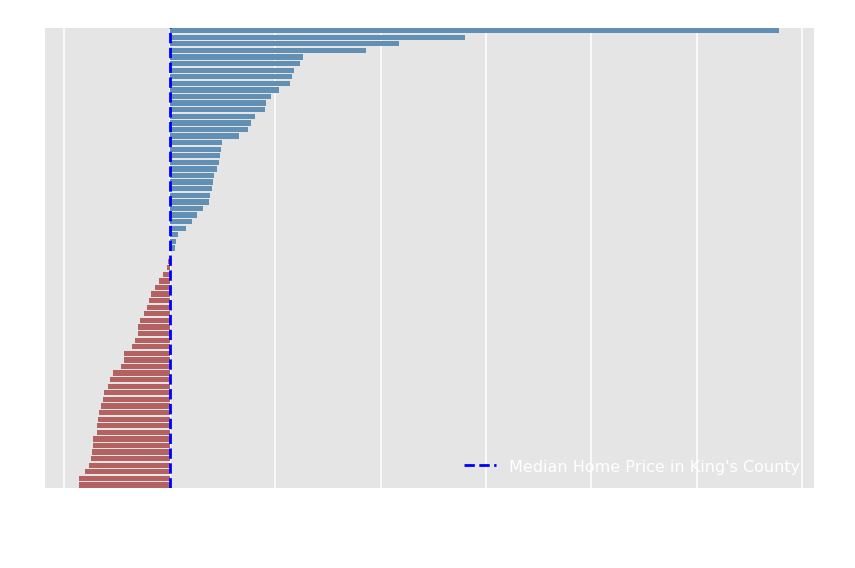

In [14]:
zipcode_fig, ax = plt.subplots(figsize=(12,8))

colors = ['#5392c2' if x > 0 else '#c25353' for x in zip_med]

sns.barplot(zip_med, zip_med.index, orient='h', 
            order=zip_med.index, palette=colors, 
            ax=ax)

apply_price_formatter(ax, yaxis=False)
ax.set_yticklabels([])

ax.set(
    title="Impact of Zipcode on Median Home Price", 
    xlabel="Difference in Median Home Price\n(Compared to King's County Median)", 
    ylabel='Zipcode'
    )
ax.axvline(x=0, color='b', ls='--', 
           label="Median Home Price in King's County")

plt.legend(framealpha=0)

zipcode_fig.tight_layout()

In [15]:
figures_dct['zipcode_fig.png'] = zipcode_fig

## Region barplot

### 1

In [16]:
# From Chris.
subregion_dict = {'south_urban': [98001, 98002, 98003, 98023, 98030, 98031, 98032, 98042, 
                                 98055, 98056, 98058, 98092, 98148, 98166, 98168, 98178, 98188,
                                 98198], 
                 'east_urban' : [98004, 98005, 98006, 98007, 98008, 98009, 98027, 98029, 
                                 98033, 98034, 98039, 98040, 98052, 98053, 98059, 98074, 
                                98075, 98077],
                 'south_rural' : [98010, 98022, 98038],
                 'north' : [98011, 98028, 98072, 98155],
                 'east_rural' : [98014, 98019, 98024, 98045, 98065],
                 'vashon_island' : [98070], 
                 'seattle' : [98102, 98103, 98105, 98106, 98107, 98108, 98109, 98112, 98115,
                             98116, 98117, 98118, 98119, 98122, 98125, 98126, 98136, 98144, 98199], 
                 'north_and_seattle' : [98133, 98177], 
                 'south_and_seattle' : [98146]}

# Mine.
zipcode_dct = {}
for k, v in subregion_dict.items():
    for zipcode in v:
        zipcode_dct[zipcode] = k
zipcode_dct

{98001: 'south_urban',
 98002: 'south_urban',
 98003: 'south_urban',
 98023: 'south_urban',
 98030: 'south_urban',
 98031: 'south_urban',
 98032: 'south_urban',
 98042: 'south_urban',
 98055: 'south_urban',
 98056: 'south_urban',
 98058: 'south_urban',
 98092: 'south_urban',
 98148: 'south_urban',
 98166: 'south_urban',
 98168: 'south_urban',
 98178: 'south_urban',
 98188: 'south_urban',
 98198: 'south_urban',
 98004: 'east_urban',
 98005: 'east_urban',
 98006: 'east_urban',
 98007: 'east_urban',
 98008: 'east_urban',
 98009: 'east_urban',
 98027: 'east_urban',
 98029: 'east_urban',
 98033: 'east_urban',
 98034: 'east_urban',
 98039: 'east_urban',
 98040: 'east_urban',
 98052: 'east_urban',
 98053: 'east_urban',
 98059: 'east_urban',
 98074: 'east_urban',
 98075: 'east_urban',
 98077: 'east_urban',
 98010: 'south_rural',
 98022: 'south_rural',
 98038: 'south_rural',
 98011: 'north',
 98028: 'north',
 98072: 'north',
 98155: 'north',
 98014: 'east_rural',
 98019: 'east_rural',
 98024: '

In [17]:
median_price['region'] = median_price['zipcode'].astype(int).replace(zipcode_dct)
median_price.head()

,zipcode,price,region
24,98039,1895000.0,east_urban
3,98004,1150000.0,east_urban
25,98040,993750.0,east_urban
48,98112,915000.0,seattle
4,98005,765475.0,east_urban


In [18]:
median_price.region.unique()

array(['east_urban', 'seattle', 'north_and_seattle', 'north',
       'east_rural', 'vashon_island', 'south_urban', 'south_rural',
       'south_and_seattle'], dtype=object)

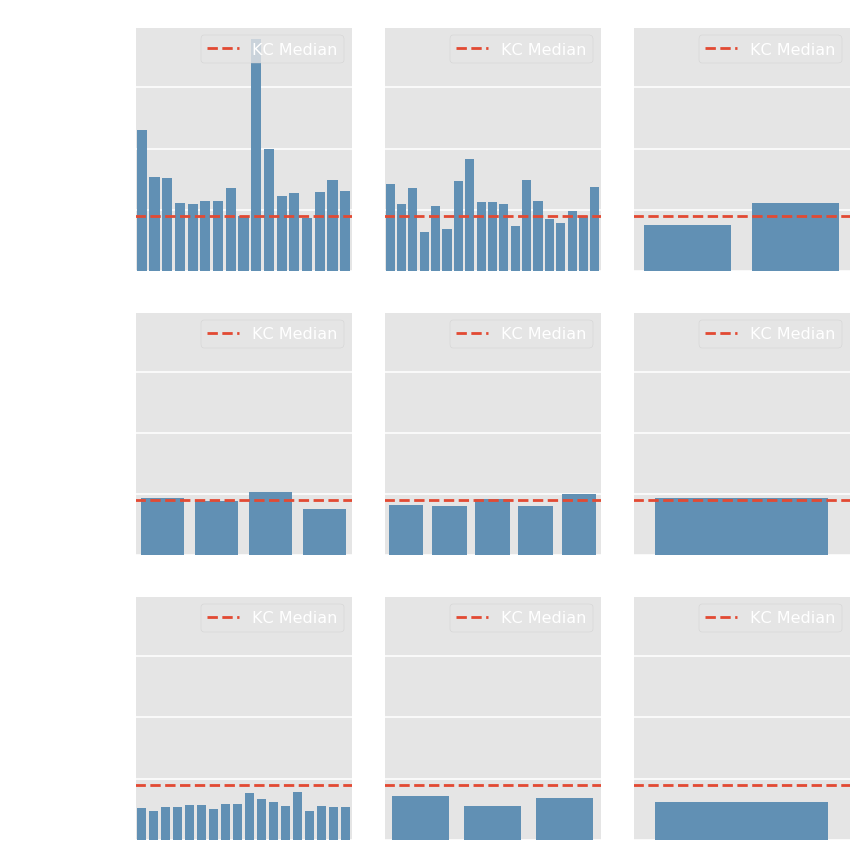

In [19]:
fig, ax_lst = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(12,12))

for region, ax in zip(median_price['region'].unique(), ax_lst.flatten()):
    sns.barplot(
        x='zipcode', 
        y='price', 
        data=median_price[median_price['region'] == region], 
        color='#5392c2',
        ax=ax)
    ax.set(title=region.replace('_', ' ').title(), xlabel='')
    ax.set_xticklabels([])
    ax.axhline(y=overall_med, ls='--', label='KC Median')
    ax.legend()
    apply_price_formatter(ax)
fig.tight_layout()

In [20]:
overall_med

450000.0

### 2

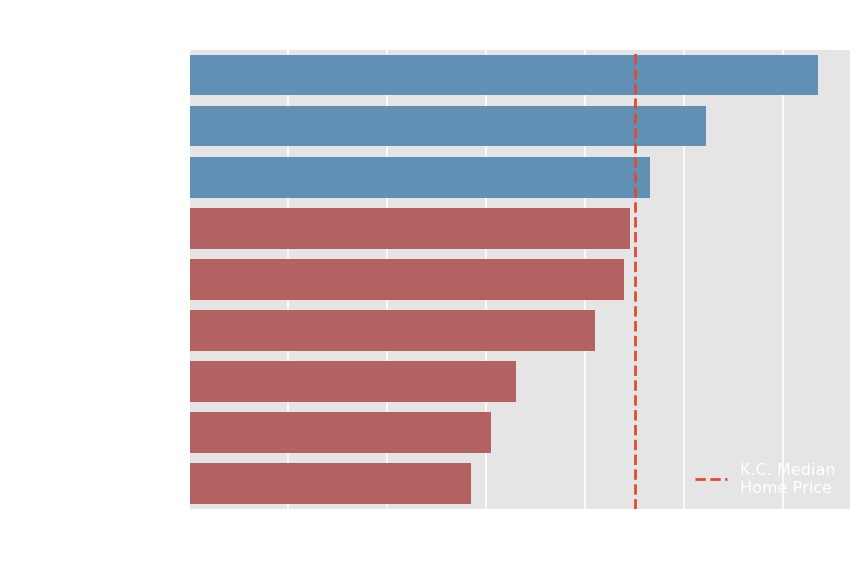

In [21]:
loc_df['region'] = loc_df['zipcode'].astype(int).replace(zipcode_dct)

region_med = loc_df.groupby('region').median().reset_index()[['price', 
                                                              'region']]
region_med.sort_values('price', ascending=False, inplace=True)
region_med['region'] = region_med['region'].apply(
    lambda x: x.replace('_', ' ').title()
    )

region_fig, ax = plt.subplots(figsize=(12,8))

colors = ['#5392c2' if x > overall_med else '#c25353' 
          for x in region_med['price']]

sns.barplot(
    x='price',
    y='region',
    orient='h', 
    data=region_med,
    order=region_med['region'],
    palette=colors,
    ax=ax)

ax.axvline(x=overall_med, ls='--', label='K.C. Median\nHome Price')
apply_price_formatter(ax, yaxis=False)

ax.set(
    title='Effect of Region\non Median Home Price',
    ylabel='Region',
    xlabel='Median Price'
    )
ax.legend(loc='lower right', framealpha=0)

region_fig.tight_layout()

In [22]:
figures_dct['region_fig.png'] = region_fig

## Stripplot

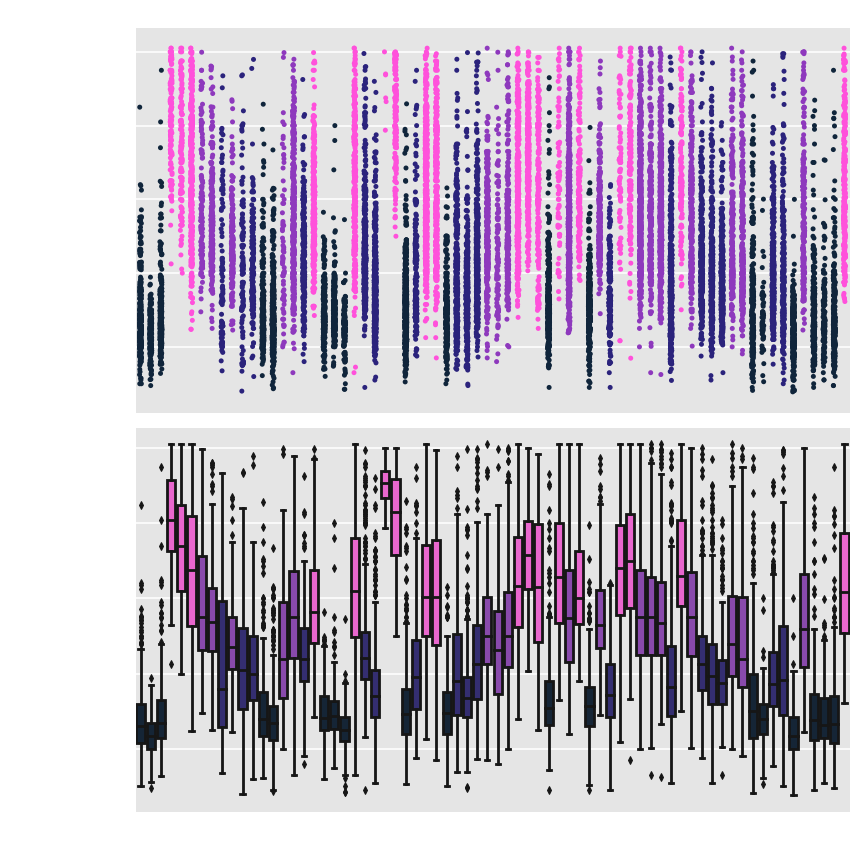

In [23]:
zip_fig_appendix, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, 
                                            figsize=(12,12))

median_price = z['price'].median()

q1, q2, q3 = [median_price.quantile(x) for x in (0.25, 0.5, 0.75)]
colors = {zipcode: '#10253B' if median_price[zipcode]<=q1
          else '#2B237C' if median_price[zipcode]<=q2
          else '#8E39BD' if median_price[zipcode]<=q3
          else '#FF51DB' for zipcode in median_price.index}

sns.stripplot(x='zipcode', y='price', data=df, palette=colors, ax=ax1)
sns.boxplot(x='zipcode', y='price', data=df, palette=colors, ax=ax2)

apply_price_formatter(ax1)
apply_price_formatter(ax2)

ax1.set(title='Zipcode Impact on Home Price', 
       xlabel='', ylabel='Home Price')
ax2.set(xlabel='Zipcode', ylabel='Home Price')
ax2.set_xticklabels([])

zip_fig_appendix.tight_layout()

In [24]:
figures_dct['zip_fig_appendix.png'] = zip_fig_appendix

# ***waterfront / renovation***

In [25]:
water_reno = df[['price', 'waterfront', 'renovated']]
water_reno.head()

,price,waterfront,renovated
0,221900,0.0,0.0
1,538000,0.0,1.0
2,180000,0.0,0.0
3,604000,0.0,0.0
4,510000,0.0,0.0


In [26]:
water_reno.head()

,price,waterfront,renovated
0,221900,0.0,0.0
1,538000,0.0,1.0
2,180000,0.0,0.0
3,604000,0.0,0.0
4,510000,0.0,0.0


## Waterfront

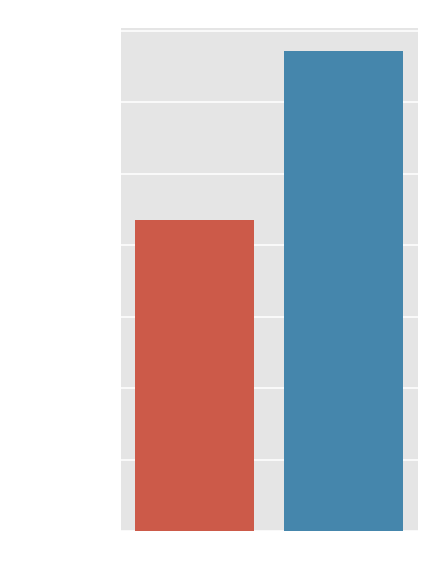

In [27]:
water_fig, ax1 = plt.subplots(figsize=(6,8))

sns.barplot(x='waterfront', y='price', estimator=np.median,
            data=water_reno, ax=ax1, ci=None)
apply_price_formatter(ax1)
ax1.set(title='Waterfront Properties', xlabel='', ylabel='Median Home Price')
ax1.set_xticklabels(['Non-Waterfront', 'Waterfront'])

water_fig.tight_layout()

### Folium

In [28]:
fol_map_waterfront = folium.Map(location=[47.56, -122.257], 
                     zoom_start=10, tiles='Stamen Terrain')

wtr = loc_df[['lat', 'long', 'waterfront']][loc_df['waterfront'] == 1.0]

for i, info in wtr.iterrows():
    lat, long = info['lat'], info['long']
    
    marker = folium.Marker(
        [lat, long],
        icon=folium.Icon('blue')
        )
    marker.add_to(fol_map_waterfront)

fol_map_waterfront

In [29]:
fol_map_waterfront.save('presentation_visualizations/fol_map_waterfront.html')

## Renovation

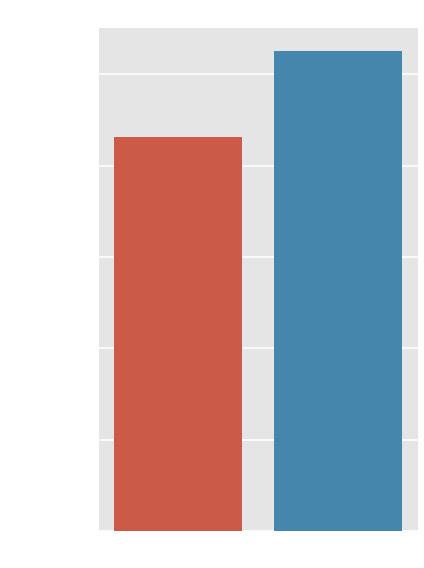

In [30]:
reno_fig, ax2 = plt.subplots(figsize=(6,8))

sns.barplot(x='renovated', y='price', data=water_reno, estimator=np.median,
            ax=ax2, ci=None)
ax2.set(title='Renovated Houses', xlabel='', ylabel='')
ax2.set_xticklabels(['Non-Renovated', 'Renovated'])
apply_price_formatter(ax2)

reno_fig.tight_layout()

Waterfront:
236000	284000

Renovated:  
43600	57300

In [31]:
figures_dct['water_fig.png'] = water_fig
figures_dct['reno_fig.png'] = reno_fig

# ***grade***

In [32]:
grade = df[['price', 'grade']].copy()
grade.head()

,price,grade
0,221900,7
1,538000,7
2,180000,6
3,604000,7
4,510000,8


In [33]:
# Get 3 values for each grade-group: 
# 1. Mean 
median = grade.groupby('grade').median()
median.columns = ['median_price']

# 2. Lower Q (0.25) 
lower_q = grade.groupby('grade').quantile(0.25)
lower_q.columns = ['lower_q']

# 3. Uppper Q (0.75)
upper_q = grade.groupby('grade').quantile(0.75)
upper_q.columns = ['upper_q']

grade_qantiles = pd.concat([lower_q, median, upper_q], axis=1)
grade_qantiles.reset_index(inplace=True)
grade_qantiles.head()

,grade,lower_q,median_price,upper_q
0,3,262000.0,262000,262000.0
1,4,142500.0,200000,273500.0
2,5,175000.0,228700,295750.0
3,6,215000.0,275000,366000.0
4,7,285000.0,375000,485000.0


In [34]:
# Slicing out grade==3 due to a lack of data.
gq = grade_qantiles[1:]

## Worm

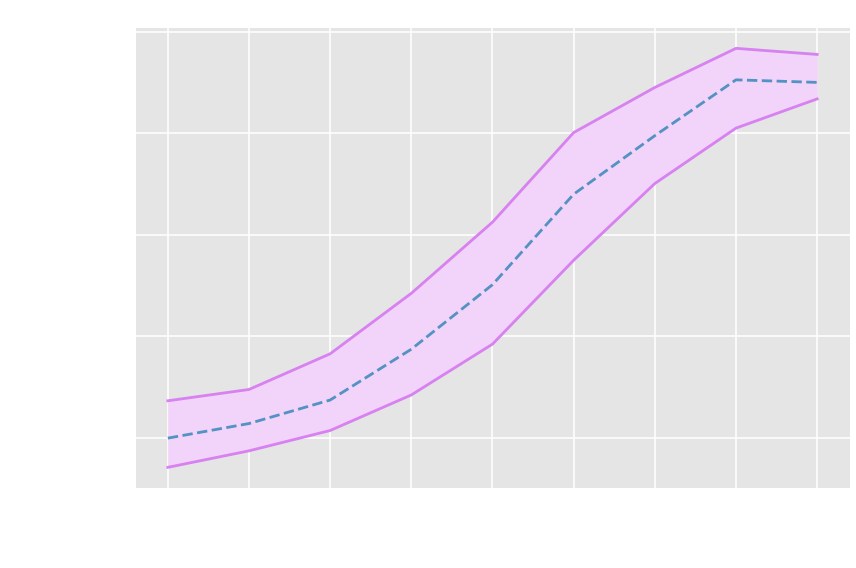

In [35]:
# Test figure1.
gradefig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(x='grade', y='lower_q', 
             color='#d881f0', data=gq, ax=ax)
sns.lineplot(x='grade', y='median_price', 
             color='#5392c2', ls='--', data=gq, ax=ax)
sns.lineplot(x='grade', y='upper_q', 
             color='#d881f0', data=gq, ax=ax)

ax.lines[1].set_linestyle("--")

apply_price_formatter(ax)
ax.set(title='Effect of House Grade on Price', 
       xlabel="Grade\n(King's County Grading System)", 
       ylabel='Median Home Price')

ax.fill_between(x=gq['grade'], y1=gq['lower_q'], y2=gq['upper_q'],
               color='#f2d4fa')
gradefig.tight_layout()

## Barplot

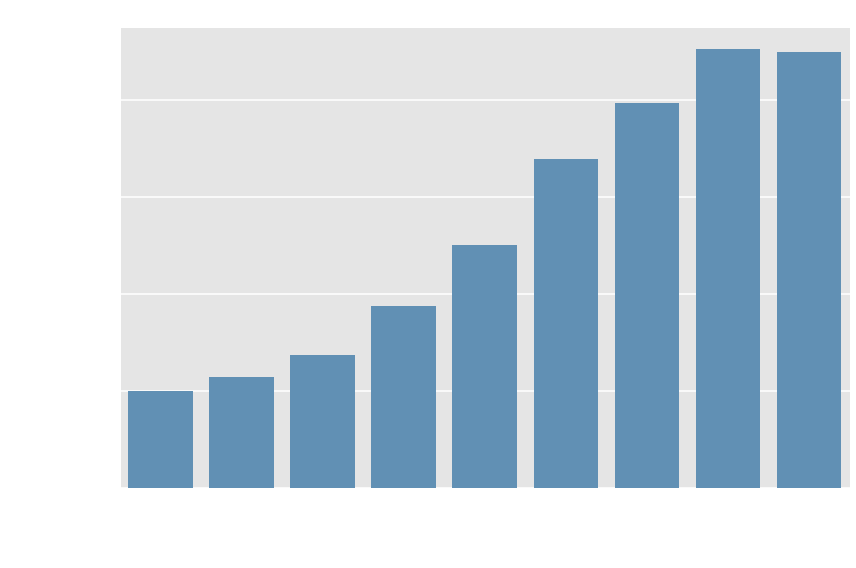

In [36]:
# Simple and good. The noble BarChart.
gradefig, ax = plt.subplots(figsize=(12,8))

sns.barplot(x='grade', y='median_price', color='#5392c2', data=gq)
apply_price_formatter(ax)

ax.set(title='Effect of Housing Grade on Price', 
       xlabel="Grade\n(King's County Grading System)", 
       ylabel='Median Home Price')

gradefig.tight_layout()

In [37]:
figures_dct['gradefig.png'] = gradefig

# ***sqft***

In [38]:
sqft = df[['price', 'sqft_above']]
sqft.head()

,price,sqft_above
0,221900,1180
1,538000,2170
2,180000,770
3,604000,1050
4,510000,1680


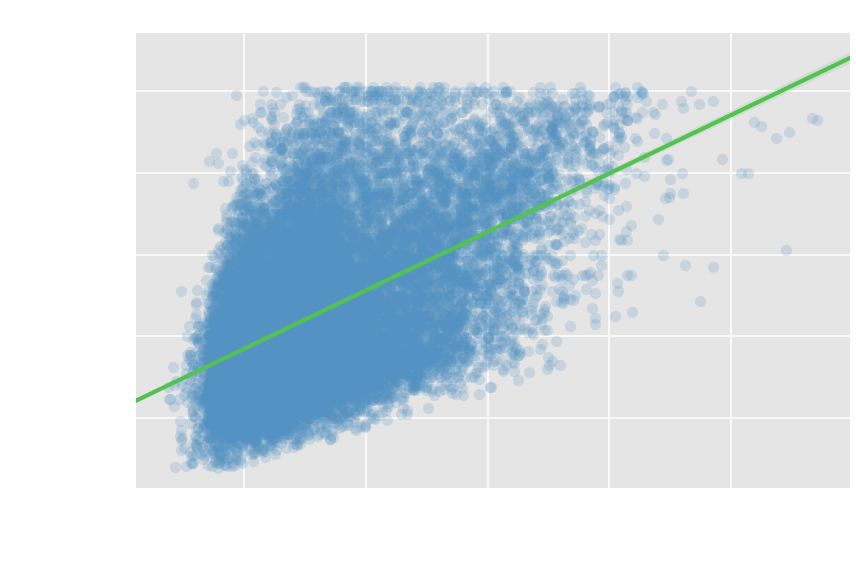

In [39]:
sqft_fig, ax = plt.subplots(figsize=(12,8))

scatter_kws = dict(
    color = '#5392c2',
    alpha = 0.2
    )
line_kws = dict(
    color = '#53c253',
    
    )

sns.regplot(x='sqft_above', y='price', data=sqft, 
            color='#5392c2', ax=ax, 
            scatter_kws=scatter_kws, line_kws=line_kws)
apply_price_formatter(ax)

ax.set(title='Price vs House Size ($ft^2$)', 
       xlabel='Square Footage\n(Above Basement)', ylabel='Home Price')

sqft_fig.tight_layout()

In [40]:
figures_dct['sqft_fig.png'] = sqft_fig

# ***Saving figures.***

In [41]:
figures_dct

{'zipcode_fig.png': <Figure size 864x576 with 1 Axes>,
 'region_fig.png': <Figure size 864x576 with 1 Axes>,
 'zip_fig_appendix.png': <Figure size 864x864 with 2 Axes>,
 'water_fig.png': <Figure size 432x576 with 1 Axes>,
 'reno_fig.png': <Figure size 432x576 with 1 Axes>,
 'gradefig.png': <Figure size 864x576 with 1 Axes>,
 'sqft_fig.png': <Figure size 864x576 with 1 Axes>}

In [42]:
# White text for dark-themed presentation.
# plt.rcParams['text.color'] = 'white'
# plt.rcParams['axes.labelcolor'] = 'white'
# plt.rcParams['xtick.color'] = 'white'
# plt.rcParams['ytick.color'] = 'white'

In [43]:
for fname, fig in figures_dct.items():
#     fig.show()
    fig.savefig(f'presentation_visualizations/{fname}', transparent=True)